In [44]:
import pandas as pd
import scipy.stats.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.distributions.copula.api import *

warnings.filterwarnings('ignore')

### Reading the data

In [45]:
df = pd.read_csv('data/mfs.csv', parse_dates=['date'], index_col='date', dayfirst=True, date_format='%d-%b-%Y')

# Downsampling to weekly data
df = df.resample('W', convention='end').apply({k: 'last' for k in df.columns}).drop(columns=['flexi', 'liquid'])

# Calculating the returns
df = df.pct_change().dropna()

# Describing the data
df.describe(percentiles=[])

,largecap,midcap,smallcap,gold
count,552.000000,552.000000,552.000000,552.000000
mean,0.003215,0.004253,0.005424,0.001480
std,0.021315,0.023039,0.026835,0.016405
min,-0.113771,-0.124562,-0.149438,-0.062393
50%,0.003980,0.005418,0.006739,0.000801
max,0.130244,0.089973,0.112077,0.087009


### Calculating the risk-free rate

In [46]:
df_liq = pd.read_csv('data/mfs.csv', parse_dates=['date'], index_col='date', dayfirst=True, date_format='%d-%b-%Y')[
    ['liquid']]

df_liq = df_liq.resample('W', convention='end').apply({k: 'last' for k in df_liq.columns}).pct_change().dropna()
risk_free_rate = (1 + df_liq.mean().values[0]) ** 52 - 1


### Fitting the marginal distributions

In [47]:
marginal_params = [dist.t.fit(df[col], floc=df[col].mean()) for col in df.columns]
marginals = [dist.t(params[0] - 1, loc=params[1], scale=params[2]) for params in marginal_params]

### Fitting the copula

In [48]:
copula = StudentTCopula(k_dim=len(df.columns), df=5, corr=df.corr())
copula.fit_corr_param(df.corr())

array([[ 1.       ,  0.5      ,  0.       , -0.5      ],
       [ 0.5      ,  1.       ,  0.8660254, -1.       ],
       [ 0.       ,  0.8660254,  1.       , -0.8660254],
       [-0.5      , -1.       , -0.8660254,  1.       ]])

### Performing simulation using the fitted model

In [49]:
model = CopulaDistribution(marginals=marginals, copula=copula)

In [50]:
df_sim = pd.DataFrame(model.rvs(10000), columns=df.columns)
df_sim.describe()

,largecap,midcap,smallcap,gold
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.003030,0.004243,0.005521,0.001388
std,0.022875,0.024133,0.029460,0.017571
min,-0.277643,-0.229087,-0.375076,-0.128336
25%,-0.009054,-0.009444,-0.009973,-0.008082
50%,0.002962,0.004298,0.005537,0.001310
75%,0.015414,0.017828,0.021023,0.011081
max,0.279913,0.209116,0.314369,0.130340


In [51]:
### Generates a vector of random weights
def get_weights(n):
    weights = np.random.random(n)
    weights /= np.sum(weights)
    return weights


def efficient_frontier(returns, iter, alpha):
    # Initialize a list of json of returns, risks and weights
    portfolio = []

    # Get the number of assets in the portfolio
    n_assets = returns.shape[1]

    # Generate the portfolios and calculate the returns and VaRs
    for i in range(iter):
        # Get random weights
        weights = get_weights(n_assets)
        portfolio_returns = (returns * weights).sum(axis=1)

        # Calculate the mean returns
        mean_returns = portfolio_returns.mean()

        # Calculate the CVaR
        var = portfolio_returns.quantile(alpha)
        cvar = -1 * portfolio_returns[portfolio_returns <= var].mean()

        # Calculate the standard deviation
        std = portfolio_returns.std()

        # Append the returns and VaRs to the lists
        portfolio.append({
            **dict(zip(returns.columns, weights)),
            'returns': mean_returns,
            'var': var,
            'std': std,
            'cvar': cvar
        })

    df = pd.DataFrame(portfolio)
    df['annual_returns'] = (df['returns'] + 1) ** 52 - 1
    df['annual_std'] = (df['std']) * (52 ** 0.5)
    df['annual_cvar'] = (df['cvar']) * (52 ** 0.5)
    df['sharpe_ratio_std'] = (df['annual_returns'] - risk_free_rate) / df['annual_std']
    df['sharpe_ratio_cvar'] = (df['annual_returns'] - risk_free_rate) / df['annual_cvar']
    return df

In [52]:
df_result = efficient_frontier(df_sim, 10000, alpha=0.10)

### Plotting the efficient frontier

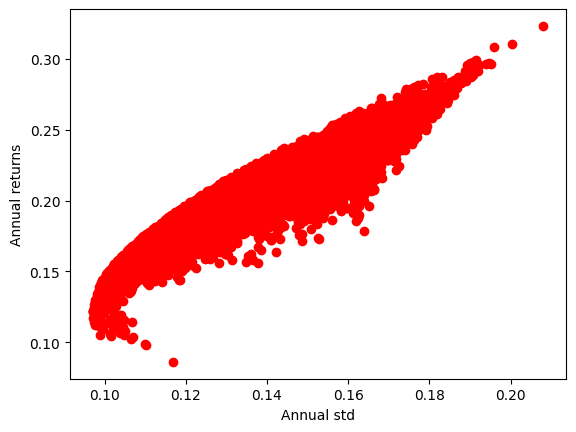

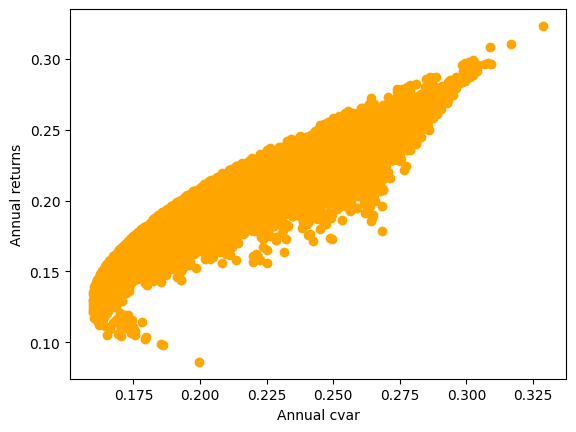

In [53]:
plt.scatter(df_result['annual_std'], df_result['annual_returns'], c='red')
plt.xlabel('Annual std')
plt.ylabel('Annual returns')
plt.show()



plt.scatter(df_result['annual_cvar'], df_result['annual_returns'], c='orange')
plt.xlabel('Annual cvar')
plt.ylabel('Annual returns')
plt.show()

In [54]:
sharpe_cvar = df_result['sharpe_ratio_cvar'].argmax()
df_result.iloc[sharpe_cvar]

largecap             0.004172
midcap               0.058066
smallcap             0.876517
gold                 0.061245
returns              0.005183
var                 -0.024165
std                  0.027156
cvar                 0.042819
annual_returns       0.308432
annual_std           0.195826
annual_cvar          0.308773
sharpe_ratio_std     1.235012
sharpe_ratio_cvar    0.783252
Name: 9166, dtype: float64

In [55]:
sharpe_std = df_result['sharpe_ratio_std'].argmax()
df_result.iloc[sharpe_std]

largecap             0.004172
midcap               0.058066
smallcap             0.876517
gold                 0.061245
returns              0.005183
var                 -0.024165
std                  0.027156
cvar                 0.042819
annual_returns       0.308432
annual_std           0.195826
annual_cvar          0.308773
sharpe_ratio_std     1.235012
sharpe_ratio_cvar    0.783252
Name: 9166, dtype: float64

In [56]:
row = df_result.iloc[sharpe_std]

In [57]:
weights = row[df_sim.columns]
historical_returns = (1 + df.mean(axis=0).values) ** 52 - 1
print(f"Historical returns with same weights: {(weights.values * historical_returns).sum()}")

Historical returns with same weights: 0.3046908441756484


In [58]:
min_cvar = df_result['annual_cvar'].argmin()
df_result.iloc[min_cvar]

largecap             0.279103
midcap               0.113400
smallcap             0.007321
gold                 0.600177
returns              0.002200
var                 -0.013116
std                  0.013460
cvar                 0.022142
annual_returns       0.121083
annual_std           0.097063
annual_cvar          0.159670
sharpe_ratio_std     0.561483
sharpe_ratio_cvar    0.341324
Name: 5651, dtype: float64